In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..') # path to preprocessing from here

from preprocessing.scripts import argParser
from preprocessing.src import Plots
from preprocessing.src import Statistics
from preprocessing.src import TimeSeries
from preprocessing.Stimuli.FreeViewing.ATV import TrialReader

In [3]:
# Some configuration variables
dataDir = "/data/perlman/moochie/user_data/SchneiderClayton/studyData/ATV_LCBD_copy_120821/data"
# episode = 1 # which episode number (1-3) we are dealing with
TR = 0.8 # this is because we'll want to have it sampled at the TR for later (s)
min_episode_samples = 900 # some recordings are shorter than others, and we don't want to include them...
ex_subs = ['102'] # any subjects to not include in the dataset
participant_num_len = 3 # default length of participant numbers

In [4]:
# build a list of all the applicable ATV data files
fnames = [join(dataDir, fname) for fname in os.listdir(dataDir)\
    if os.path.basename(fname)[:participant_num_len] not in ex_subs]

dataset = []
print("Loading ATV files as TimeSeries objects:")
print("==========")
for fpath in tqdm(fnames):
    try:
        # for each filepath in the list, run an ATV.TrialReader builder
        # add each src.TimeSeries object generated from the TrialReader to
        # the dataset list
        for ts in TrialReader(fpath).ratingsSeries:
            dataset.append(ts)
    except:
        print("Failure to read:", os.path.basename(fpath))
        pass

Loading ATV files as TimeSeries objects:


100%|██████████| 17/17 [00:26<00:00,  1.55s/it]


In [5]:
print("Preprocessing TimeSeries:")
print("==========")
for ts in tqdm(dataset):
    ts.fix_nan()
    ts.lag_correct()
    ts.resample(sample_rate=TR)

Preprocessing TimeSeries:


100%|██████████| 47/47 [00:09<00:00,  5.10it/s]


Inspecting Lengths of Ratings in Each Episode:


100%|██████████| 3/3 [00:00<00:00, 80.89it/s]


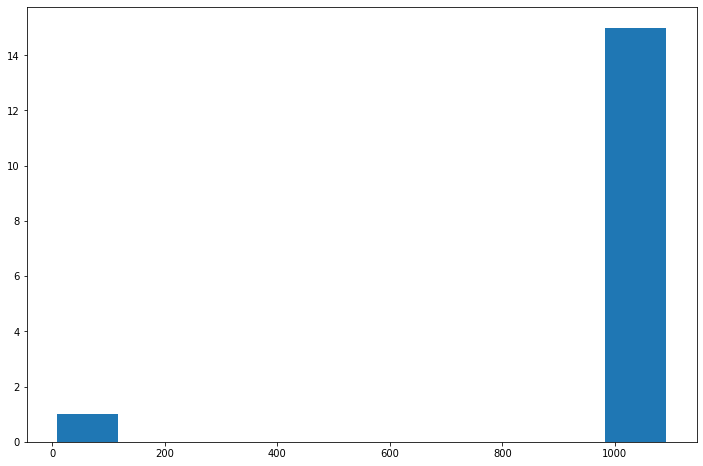

In [6]:
print("Inspecting Lengths of Ratings in Each Episode:")
print("==========")
episodes = []

for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    plt.hist([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode])

Inspecting Lengths of Ratings in Each Episode After Dropping:


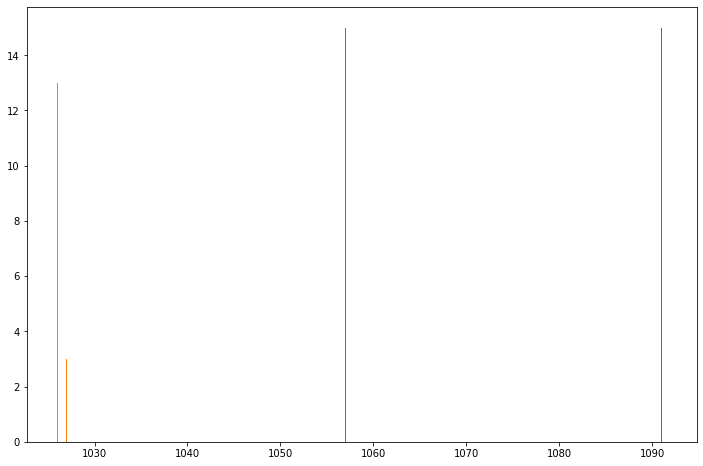

In [7]:
print("Inspecting Lengths of Ratings in Each Episode After Dropping:")
print("==========")

dataset = [ts for ts in dataset if len(ts.signal) > min_episode_samples]

for episode in episodes:
    plt.hist([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode])

In [8]:
print("Matching Lengths and Discretizing with Averages of Each:")
print("==========")

episodes = []
d_dataset = {}
d_avgs = {}
# truncate each batch of runs with the same episode to the length of the
# shortest trial in the batch
for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    ep_min = min([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode and len(ts.signal) > min_episode_samples])
    for ts in [ts for ts in dataset if ts.meta['episode']==episode]:
        ts.signal = ts.signal[:ep_min]
        ts.time = ts.time[:ep_min]
        
    # discretize the dataset to a dict with entry for each episode
    d_dataset[episode] = [ts for ts in dataset if ts.meta['episode'] == episode]
    # make averages (discretized) of each episode's runs (same struc as d_dataset)
    d_avgs[episode] = TimeSeries.TimeSeries(
        signal=np.average(np.array([ts.signal for ts in d_dataset[episode]]), axis=0),
        time=ts.time,
        meta={
            'participant': 'AVG',
            'episode': episode})

Matching Lengths and Discretizing with Averages of Each:


100%|██████████| 3/3 [00:00<00:00, 3883.61it/s]


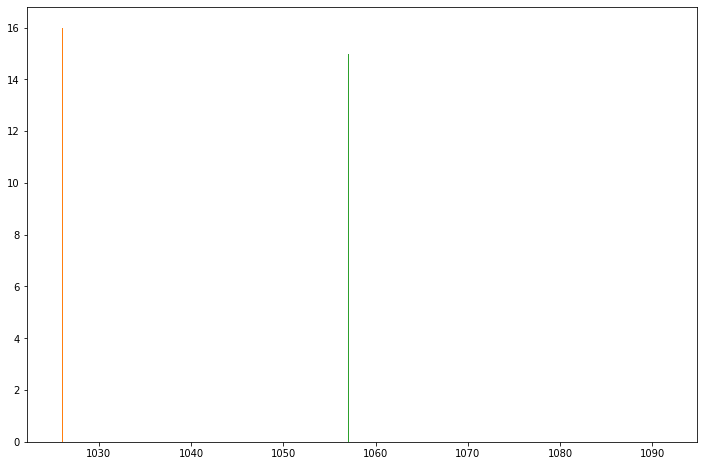

In [9]:
for episode in episodes:
    plt.hist([len(ts.signal) for ts in d_dataset[episode]])

In [10]:
# just view the structure of this object
print(d_dataset)
print(d_avgs)

{0: [<preprocessing.src.TimeSeries.TimeSeries object at 0x7f3877846750>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f38751433d0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3877846f50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3875143c50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3877846d50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f387782fa90>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3877846c50>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f387782f890>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3877846f10>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3875143850>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3877846910>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f387515bb10>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f3875143190>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7f387515b490>, <preprocessing.src.TimeSeries.TimeSeries ob

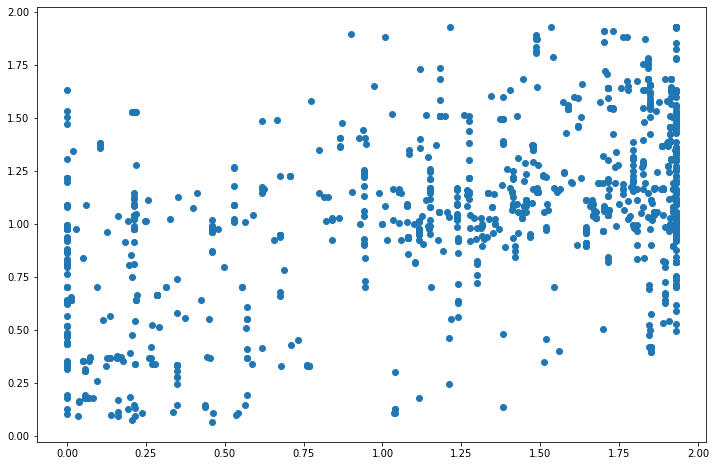

In [11]:
plt.scatter(
    d_dataset[0][0].signal,
    d_dataset[0][1].signal)

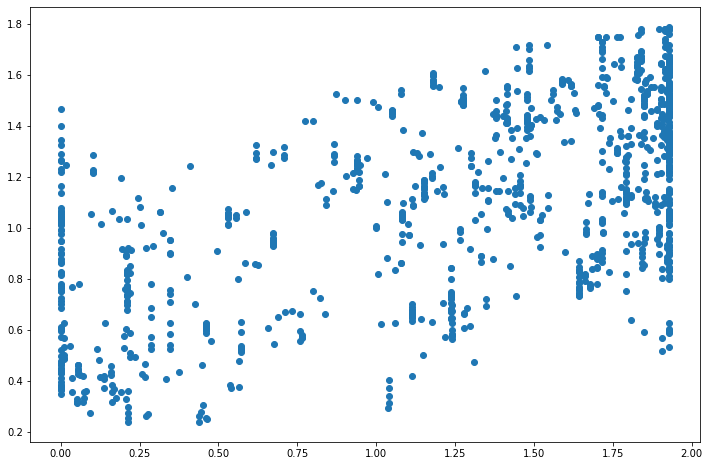

In [12]:
plt.scatter(
    d_dataset[0][0].signal,
    d_avgs[0].signal)

In [13]:
d_dataset[0][0].__dict__

{'signal': array([1.       , 1.       , 1.1      , ..., 1.7037037, 1.7037037,
        1.7037037]),
 'time': array([0.00000000e+00, 1.25137615e+00, 2.50275229e+00, ...,
        1.36149725e+03, 1.36274862e+03, 1.36400000e+03]),
 'sampleRate': 0.8,
 'meta': {'participant': '111', 'episode': 0, 'viewingOrder': 'BAC'},
 'unit': 's'}

In [14]:
d_dataset[0][0].meta['participant']

'111'

In [15]:
Statistics.simple_icc(
    d_dataset[0][0],
    d_dataset[0][1])

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.432949,2.527019,1090,1091,1.925049e-51,"[0.38, 0.48]"
1,ICC2,Single random raters,0.447854,2.792949,1090,1090,3.533879e-62,"[0.36, 0.52]"
2,ICC3,Single fixed raters,0.472706,2.792949,1090,1090,3.533879e-62,"[0.43, 0.52]"
3,ICC1k,Average raters absolute,0.604277,2.527019,1090,1091,1.925049e-51,"[0.55, 0.65]"
4,ICC2k,Average random raters,0.618646,2.792949,1090,1090,3.533879e-62,"[0.53, 0.69]"
5,ICC3k,Average fixed raters,0.641955,2.792949,1090,1090,3.533879e-62,"[0.6, 0.68]"


In [16]:
Statistics.simple_icc(
    d_dataset[0][0],
    d_avgs[0])

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.500820,3.006571,1090,1091,9.731431e-71,"[0.46, 0.54]"
1,ICC2,Single random raters,0.509589,3.238593,1090,1090,8.986164e-80,"[0.44, 0.57]"
2,ICC3,Single fixed raters,0.528145,3.238593,1090,1090,8.986164e-80,"[0.48, 0.57]"
3,ICC1k,Average raters absolute,0.667395,3.006571,1090,1091,9.731431e-71,"[0.63, 0.7]"
4,ICC2k,Average random raters,0.675136,3.238593,1090,1090,8.986164e-80,"[0.61, 0.73]"
5,ICC3k,Average fixed raters,0.691224,3.238593,1090,1090,8.986164e-80,"[0.65, 0.73]"


In [24]:
# initialize empty array for icc values (one per timepoint)
iccs = {}

for episode in episodes:
    
    xticklabels = list(set([ts.meta['participant'] for ts in d_dataset[episode]]))
    xticklabels.append('avg')
    
    yticklabels = xticklabels
    
    icc1df = pd.DataFrame(
        columns=xticklabels,
        index=yticklabels)
    
    for rowIndex, row in enumerate(icc1df.index):
        for colIndex, col in enumerate(icc1df.columns):
#             print("col:", col, "row:", row)
            
            # case that we are in upper-right triangle of matrix
            if rowIndex < colIndex:
                # grab X
                if col == 'avg':
                    X = d_avgs[episode]
                else:
                    X = [ts for ts in d_dataset[episode] if ts.meta['participant']==col]
#                     if len(X) != 1:
#                         print("ERROR")
                    X = X[0]
                    
                # grab Y
                if row == 'avg':
                    Y = d_avgs[episode]
                else:
                    Y = [ts for ts in d_dataset[episode] if ts.meta['participant']==row]
#                     if len(Y) != 0:
#                         print("ERROR")
                    Y = Y[0]

                try:
                    iccval = Statistics.simple_icc(X, Y)

                    icc1df.iat[rowIndex, colIndex] = iccval.iat[0,2]
                    
#                     if iccval.iat[0, 6] < 0.05:
#                         icc1df.iat[rowIndex, colIndex] = icc1df.iat[rowIndex, colIndex]+"*"
                    
                except:
                    icc1df.iat[rowIndex, colIndex] = 0
                    print("Err @ row ", row, "col", col)
            # case we are on diagonal
            elif rowIndex == colIndex:
                icc1df.iat[rowIndex, colIndex] = 1
            # case thta we are in bottom-left triangle of matrix
            else:
                icc1df.iat[rowIndex, colIndex] = icc1df.iat[colIndex, rowIndex]
            
    iccs[episode] = icc1df
    
#     iccs[episode] = np.array(d_dataset[episode][0].signal.shape)

#     # traverse through axis 1 / columns / timeoints
#     for i, col in enumerate(np.array([ts.signal for ts in purged_dataset]).T):
#         # append icc for timepoint to iccs
#         iccs[episode][i] = Statistics.icc(
#             np.array(col),
#             icc_type='ICC(1,1)')

Err @ row  103 col 112
Err @ row  103 col 116
Err @ row  103 col 104
Err @ row  103 col avg
Err @ row  111 col 112
Err @ row  111 col 116
Err @ row  111 col 104
Err @ row  111 col avg
Err @ row  110 col 112
Err @ row  110 col 116
Err @ row  110 col 104
Err @ row  110 col avg
Err @ row  108 col 112
Err @ row  108 col 116
Err @ row  108 col 104
Err @ row  108 col avg
Err @ row  112 col 115
Err @ row  112 col 107
Err @ row  112 col 105
Err @ row  112 col 116
Err @ row  112 col 109
Err @ row  112 col 114
Err @ row  112 col 101
Err @ row  112 col 113
Err @ row  112 col 100
Err @ row  112 col 106
Err @ row  112 col avg
Err @ row  115 col 116
Err @ row  115 col 104
Err @ row  115 col avg
Err @ row  107 col 116
Err @ row  107 col 104
Err @ row  107 col avg
Err @ row  105 col 116
Err @ row  105 col 104
Err @ row  105 col avg
Err @ row  116 col 109
Err @ row  116 col 114
Err @ row  116 col 101
Err @ row  116 col 113
Err @ row  116 col 100
Err @ row  116 col 104
Err @ row  116 col 106
Err @ row  

In [31]:
iccs[2]

,103,111,110,108,112,115,107,105,109,114,101,113,100,104,106,avg
103,1,0.18767,0.409885,0.427427,0.416321,0.203084,0.153511,0.467798,0.178106,0.536374,0.130177,-0.047503,0.134011,0.339273,0.243619,0.459399
111,0.18767,1,0.248835,0.229715,0.267388,0.236241,0.182191,0.27126,0.192701,0.141686,0.353819,0.261095,0.314412,0.363161,0.26188,0.426053
110,0.409885,0.248835,1,0.367006,0.527038,0.419298,0.16851,0.550539,0.240012,0.45153,0.123918,-0.006855,0.22071,0.342859,0.164647,0.581823
108,0.427427,0.229715,0.367006,1,0.52966,0.192315,0.225765,0.452656,0.244353,0.452397,0.232747,-0.036895,0.282829,0.454074,0.449644,0.568809
112,0.416321,0.267388,0.527038,0.52966,1,0.47554,0.266745,0.586002,0.273146,0.484688,0.316574,-0.006837,0.424893,0.489586,0.286624,0.697184
115,0.203084,0.236241,0.419298,0.192315,0.47554,1,0.152957,0.455745,0.107162,0.255762,0.119424,-0.029534,0.182112,0.133385,0.065165,0.488133
107,0.153511,0.182191,0.16851,0.225765,0.266745,0.152957,1,0.318375,0.158369,0.06979,0.131364,0.021435,0.131343,0.34616,0.099723,0.462077
105,0.467798,0.27126,0.550539,0.452656,0.586002,0.455745,0.318375,1,0.410004,0.496029,0.26354,0.039035,0.326132,0.496319,0.182988,0.739873
109,0.178106,0.192701,0.240012,0.244353,0.273146,0.107162,0.158369,0.410004,1,0.14403,0.386484,0.256409,0.389185,0.383272,0.105372,0.526869
114,0.536374,0.141686,0.45153,0.452397,0.484688,0.255762,0.06979,0.496029,0.14403,1,0.087232,-0.218228,0.061521,0.282211,0.242757,0.437491


In [32]:
cmatrix = np.array(iccs[2]).astype(float)

In [33]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

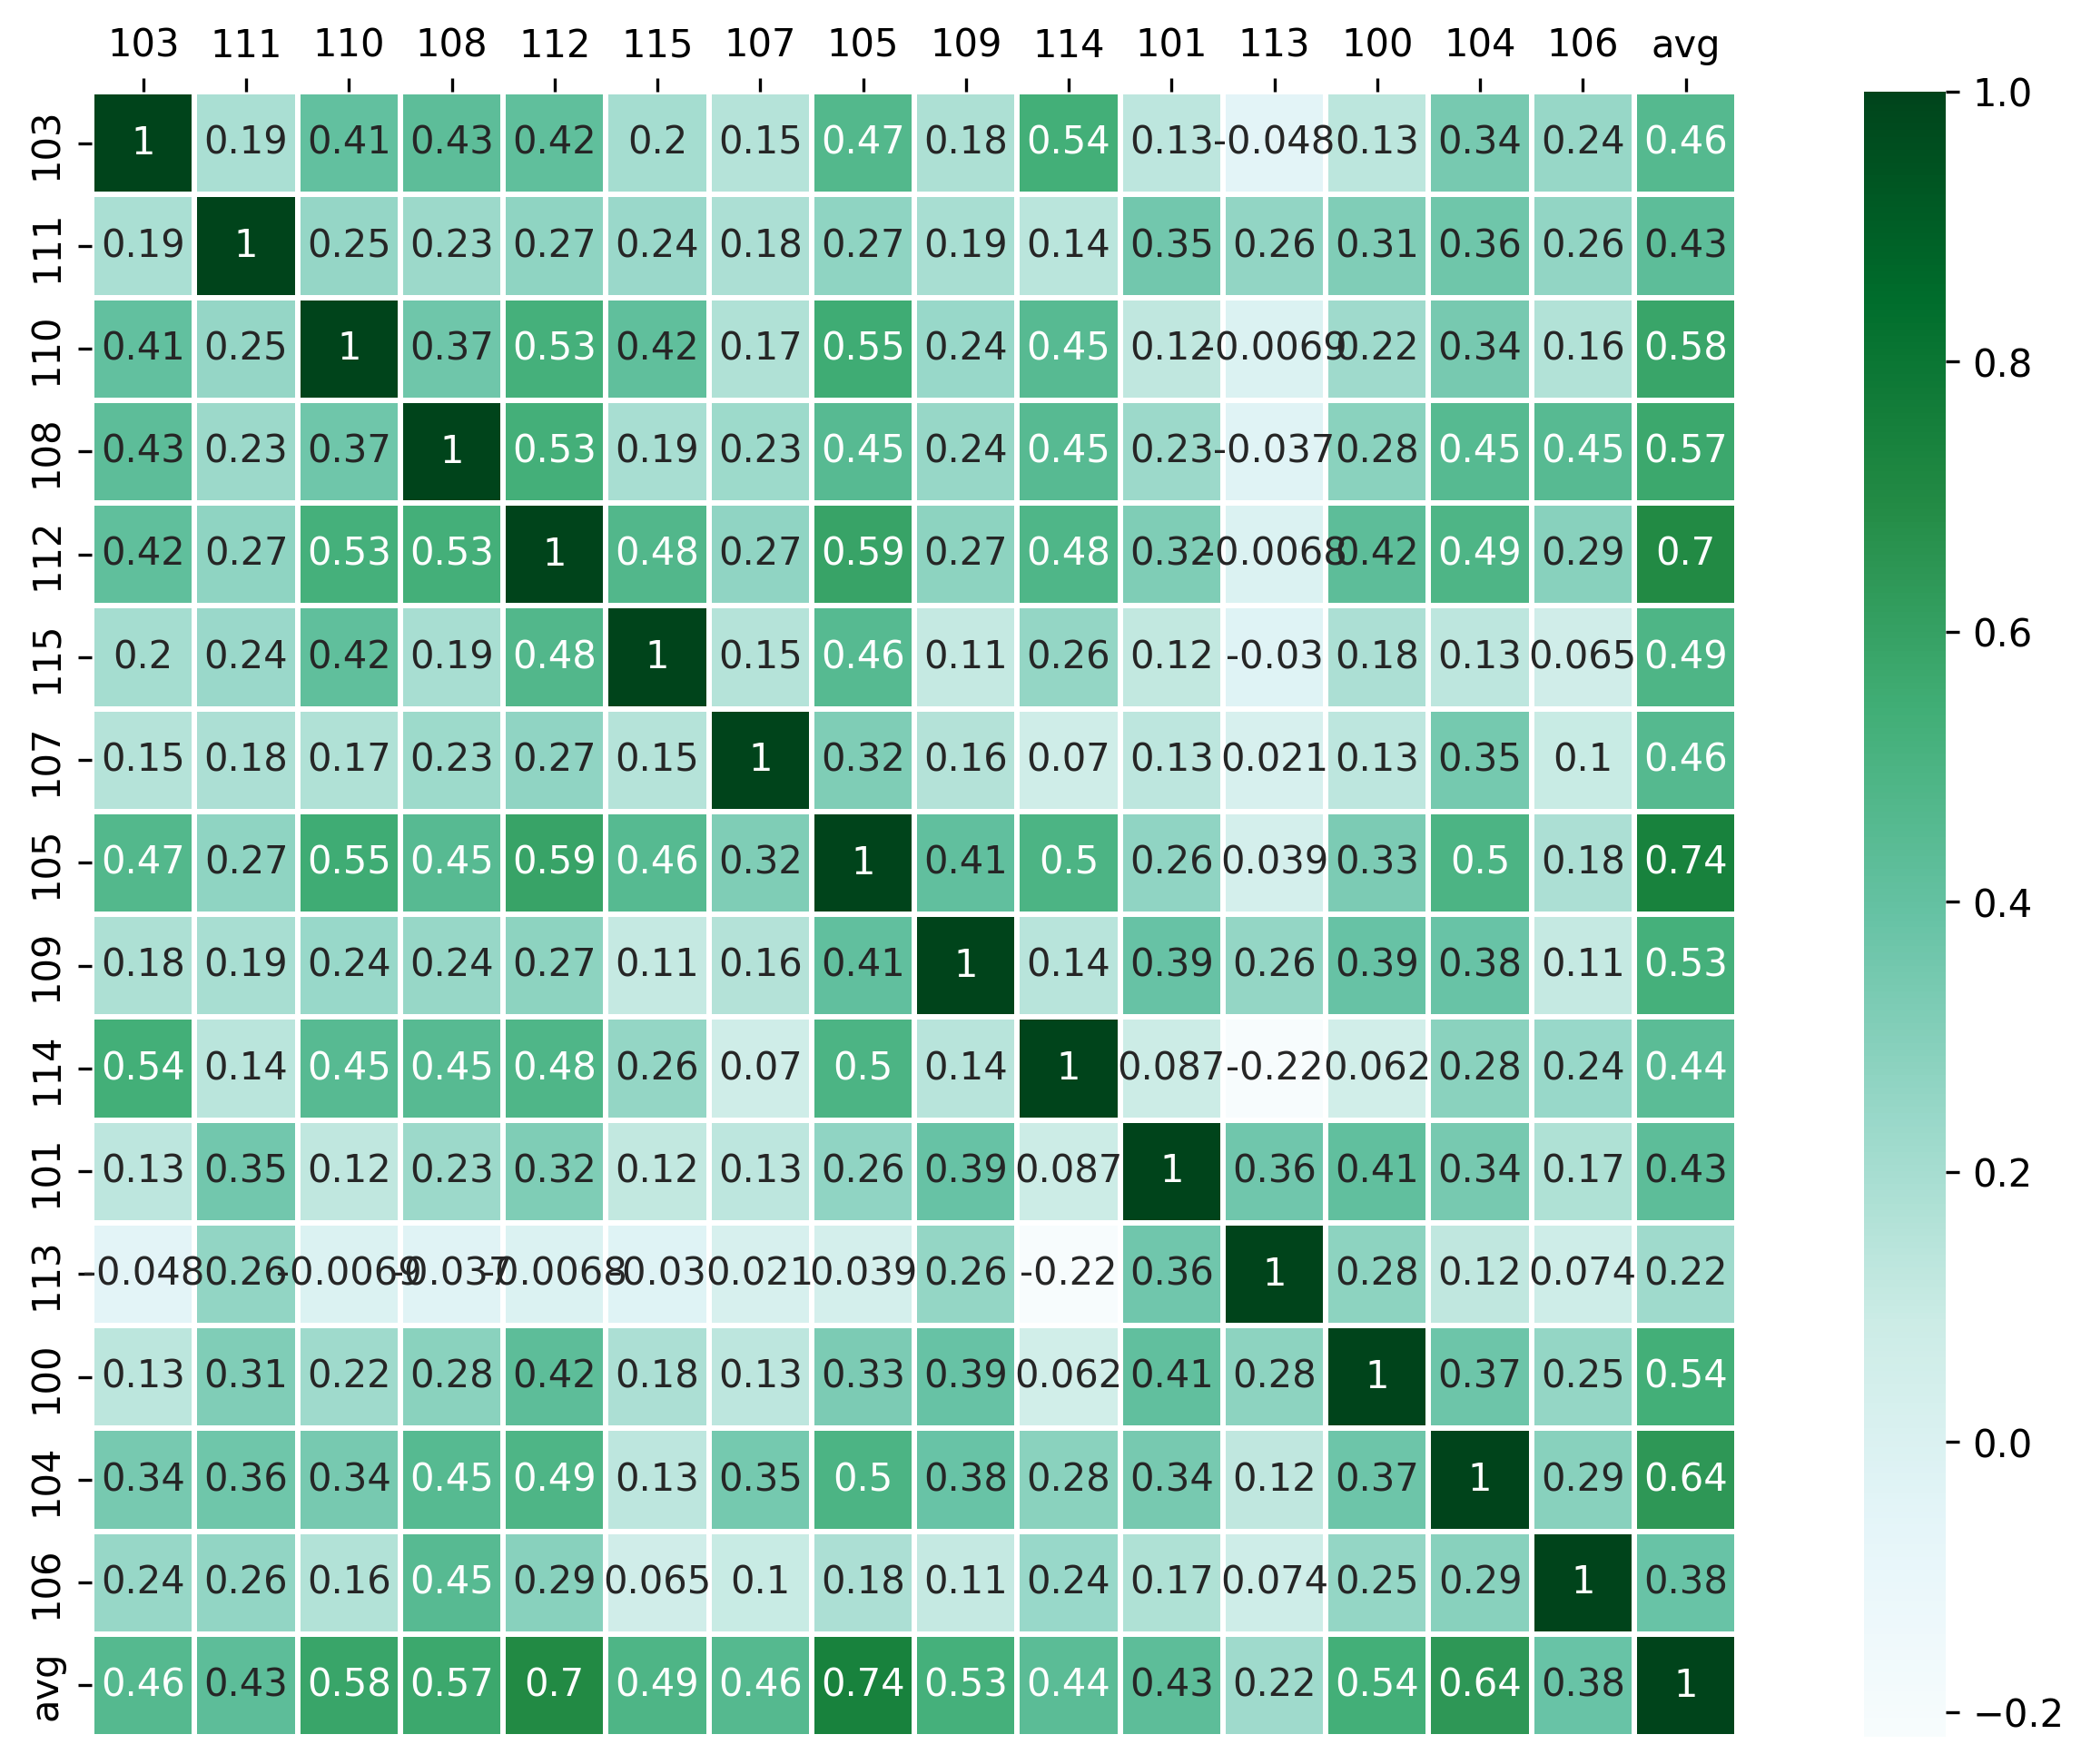

In [35]:
ax = sns.heatmap(
    cmatrix,
    annot=True,
    xticklabels=[str(col) for col in iccs[0].columns],
    yticklabels=[str(ind) for ind in iccs[0].index],
#     cmap=sns.diverging_palette(20, 220, n=200),
    cmap="BuGn",
    linewidths=1,
    square=True,
#     vmin=-1,
#     vmax=1
)

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

# ax.set_xticklabels(
#     [str(col) for col in iccs[0].columns],
#     rotation=45,
#     horizontalalignment='right')